# 🌞**Évaluation et Prévision des Énergies Renouvelables Variables (ERV)**

## 🎯 **Objectifs du Projet**

1. **Évaluer la production horaire des installations photovoltaïques** dans les régions de la France métropolitaine en utilisant des données climatiques et des observations des facteurs de capacité.

2. **Prédire la production énergétique des ERV à l'avance**, afin de mieux anticiper les variations de puissance et optimiser la gestion du réseau électrique.




---

## Lire les donnéees

Récupérer les données de production solaire 

In [21]:
!pip install requests
!pip install xarray netcdf4
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.5 MB/s eta 0:00:00


In [14]:
import requests
import pandas as pd
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

# Liste des URLs pour chaque région
urls = {
    "Auvergne-Rhône-Alpes": "/api/explore/v2.1/catalog/datasets/production-regionale-mensuelle-filiere/records?select=mois%2Cregion%2Cproduction_solaire&where=mois%3C2020&limit=100&refine=region%3A%22Auvergne-Rh%C3%B4ne-Alpes%22",
    "Bourgogne-Franche-Comté": "/api/explore/v2.1/catalog/datasets/production-regionale-mensuelle-filiere/records?select=mois%2Cregion%2Cproduction_solaire&where=mois%3C2020&limit=100&refine=region%3A%22Bourgogne-Franche-Comt%C3%A9%22",
    "Bretagne": "/api/explore/v2.1/catalog/datasets/production-regionale-mensuelle-filiere/records?select=mois%2Cregion%2Cproduction_solaire&where=mois%3C2020&limit=100&refine=region%3A%22Bretagne%22",
    "Centre-Val de Loire": "/api/explore/v2.1/catalog/datasets/production-regionale-mensuelle-filiere/records?select=mois%2Cregion%2Cproduction_solaire&where=mois%3C2020&limit=100&refine=region%3A%22Centre-Val%20de%20Loire%22",
    "Grand Est": "/api/explore/v2.1/catalog/datasets/production-regionale-mensuelle-filiere/records?select=mois%2Cregion%2Cproduction_solaire&where=mois%3C2020&limit=100&refine=region%3A%22Grand%20Est%22",
    "Hauts-de-France": "/api/explore/v2.1/catalog/datasets/production-regionale-mensuelle-filiere/records?select=mois%2Cregion%2Cproduction_solaire&where=mois%3C2020&limit=100&refine=region%3A%22Hauts-de-France%22",
    "Île-de-France": "/api/explore/v2.1/catalog/datasets/production-regionale-mensuelle-filiere/records?select=mois%2Cregion%2Cproduction_solaire&where=mois%3C2020&limit=100&refine=region%3A%22%C3%8Ele-de-France%22",
    "Normandie": "/api/explore/v2.1/catalog/datasets/production-regionale-mensuelle-filiere/records?select=mois%2Cregion%2Cproduction_solaire&where=mois%3C2020&limit=100&refine=region%3A%22Normandie%22",
    "Nouvelle-Aquitaine": "/api/explore/v2.1/catalog/datasets/production-regionale-mensuelle-filiere/records?select=mois%2Cregion%2Cproduction_solaire&where=mois%3C2020&limit=100&refine=region%3A%22Nouvelle-Aquitaine%22",
    "Occitanie": "/api/explore/v2.1/catalog/datasets/production-regionale-mensuelle-filiere/records?select=mois%2Cregion%2Cproduction_solaire&where=mois%3C2020&limit=100&refine=region%3A%22Occitanie%22",
    "Pays de la Loire": "/api/explore/v2.1/catalog/datasets/production-regionale-mensuelle-filiere/records?select=mois%2Cregion%2Cproduction_solaire&where=mois%3C2020&limit=100&refine=region%3A%22Pays%20de%20la%20Loire%22",
    "Provence-Alpes-Côte d'Azur": "/api/explore/v2.1/catalog/datasets/production-regionale-mensuelle-filiere/records?select=mois%2Cregion%2Cproduction_solaire&where=mois%3C2020&limit=100&refine=region%3A%22Provence-Alpes-C%C3%B4te%20d'Azur%22"
}

# Base URL pour l'API
base_url = "https://odre.opendatasoft.com"

# Configurer le retry pour gérer les échecs temporaires
session = requests.Session()
retries = Retry(total=5, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
session.mount('https://', HTTPAdapter(max_retries=retries))

# Liste pour collecter les données de toutes les régions
all_data = []

# Plage de dates filtrées
date_range_start = "2014-01"
date_range_end = "2019-12"

for region, endpoint in urls.items():
    try:
        # Effectuer une requête GET pour chaque région
        response = session.get(base_url + endpoint, timeout=30)
        response.raise_for_status()  # Vérifier si la requête a réussi

        # Charger les données JSON
        data = response.json()
        results = data.get("results", [])

        # Extraire les champs pertinents en filtrant par date
        formatted_data = [
            {
                "mois": record.get("mois"),
                "region": region,
                "production_solaire": record.get("production_solaire")
            }
            for record in results
            if date_range_start <= record.get("mois", "") <= date_range_end
        ]

        # Ajouter les données de cette région à la liste globale
        all_data.extend(formatted_data)

    except requests.exceptions.RequestException as e:
        print(f"Erreur lors de la récupération des données pour {region} : {e}")

# Créer un DataFrame pandas avec toutes les données
df = pd.DataFrame(all_data)

# Réorganiser le format du tableau pour avoir les régions comme colonnes
df_pivot = df.pivot(index="mois", columns="region", values="production_solaire").reset_index()
df_pivot.columns.name = None  # Supprimer le nom des colonnes multi-index
df_pivot['mois'] = pd.to_datetime(df_pivot['mois'], format='%Y-%m')

# Exporter les données au format CSV
output_path = "production_solaire_2014_2019.csv"
df_pivot.to_csv(output_path, index=False)

output_path  # Chemin du fichier exporté


'production_solaire_2014_2019.csv'

In [15]:
import requests
import pandas as pd
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

# URL de l'API
url = "https://odre.opendatasoft.com/api/explore/v2.1/catalog/datasets/parc-regional-annuel-prod-eolien-solaire/records?select=annee%2Cregion%2Cparc_installe_solaire&where=annee%3E2013%20AND%20annee%3C2021&limit=100"

# Configurer le retry pour gérer les échecs temporaires
session = requests.Session()
retries = Retry(total=5, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
session.mount('https://', HTTPAdapter(max_retries=retries))

try:
    # Effectuer une requête GET
    response = session.get(url, timeout=30)
    response.raise_for_status()  # Vérifie si la requête a réussi

    # Charger les données JSON
    data = response.json()
    results = data.get("results", [])

    # Extraire les champs pertinents
    formatted_data = [
        {
            "annee": record.get("annee"),
            "region": record.get("region"),
            "parc_installe_solaire": record.get("parc_installe_solaire")
        }
        for record in results
    ]

    # Créer un DataFrame pandas
    df = pd.DataFrame(formatted_data)

    # Réorganiser le tableau pour qu'il soit structuré par année et région
    df_pivot = df.pivot(index="annee", columns="region", values="parc_installe_solaire").reset_index()
    df_pivot.columns.name = None  # Supprimer le nom des colonnes multi-index

    # Exporter les données au format CSV
    output_path = "parc_installe_solaire_2014_2019.csv"
    df_pivot.to_csv(output_path, index=False)

    print(f"Données exportées avec succès : {output_path}")

except requests.exceptions.RequestException as e:
    print(f"Erreur lors de la requête API : {e}")
except Exception as e:
    print(f"Erreur générale : {e}")


Données exportées avec succès : parc_installe_solaire_2014_2019.csv


In [16]:
import pandas as pd

# Charger les deux fichiers existants
production_solaire_df = pd.read_csv("production_solaire_2014_2019.csv")
parc_installe_solaire_df = pd.read_csv("parc_installe_solaire_2014_2019.csv")

# Assurez-vous que les deux fichiers sont alignés sur les mêmes colonnes et années
production_solaire_df['annee'] = pd.to_datetime(production_solaire_df['mois']).dt.year
parc_installe_solaire_df = parc_installe_solaire_df.set_index("annee")

# Diviser les valeurs de production solaire par le parc installé correspondant
for region in production_solaire_df.columns[1:-1]:  # Ignorer 'mois' et 'annee'
    if region in parc_installe_solaire_df.columns:
        production_solaire_df[region] = production_solaire_df.apply(
            lambda row: row[region] / parc_installe_solaire_df.loc[row['annee'], region]
            if not pd.isna(row[region]) and not pd.isna(parc_installe_solaire_df.loc[row['annee'], region]) else None,
            axis=1
        )

# Multiplier toutes les valeurs par 1000 (conversion de GWh à MWh)
# Diviser ensuite par 24 * 30.5 (heures dans un mois)
conversion_factor = 1000 / (24 * 30.5)
production_solaire_df.iloc[:, 1:] = production_solaire_df.iloc[:, 1:] * conversion_factor

# Supprimer la colonne 'annee' (elle était temporaire)
production_solaire_df = production_solaire_df.drop(columns=['annee'])

# Exporter le nouveau fichier CSV
output_path = "normalized_production_solaire_2014_2019.csv"
production_solaire_df.to_csv(output_path, index=False)

print(f"Données normalisées et converties exportées avec succès : {output_path}")


Données normalisées et converties exportées avec succès : normalized_production_solaire_2014_2019.csv


/tmp/ipykernel_1061/1280283660.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0     2751.366120
1     2751.366120
2     2751.366120
3     2751.366120
4     2751.366120
         ...     
67    2758.196721
68    2758.196721
69    2758.196721
70    2758.196721
71    2758.196721
Name: annee, Length: 72, dtype: float64' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  production_solaire_df.iloc[:, 1:] = production_solaire_df.iloc[:, 1:] * conversion_factor


<Axes: xlabel='mois'>

<Figure size 640x480 with 0 Axes>

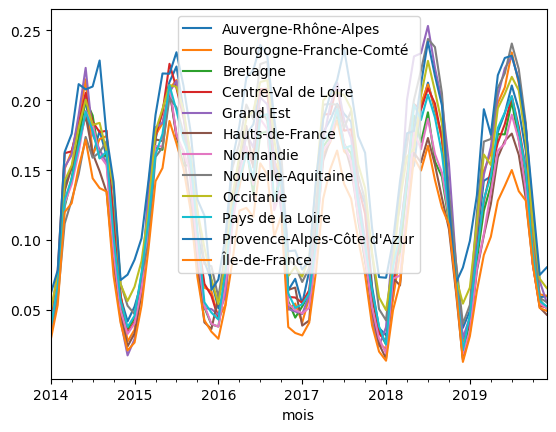

In [17]:
import matplotlib.pyplot as plt

filepath2='normalized_production_solaire_2014_2019.csv'
df_energy2 = pd.read_csv(filepath2, index_col=0, header=0, parse_dates=True)
plt.figure()
df_energy2.plot()

Récupérer les données climatiques 

In [22]:
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

data_dir_climate = "data"
filename_climate = 'merra2_area_selection_output_{}_merra2_2010-2019.nc'



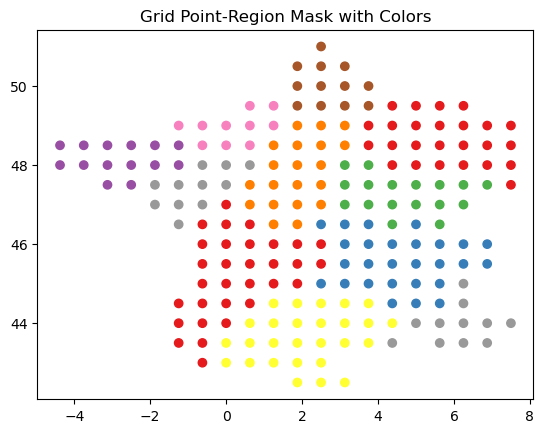

In [23]:

filename_mask = "mask_datagouv_french_regions_merra2_Nx_France.nc"

filepath_mask = Path(data_dir_climate, filename_mask)
 # Read and plot grid point-region mask

ds_mask = xr.load_dataset(filepath_mask, engine='netcdf4')
da_mask = ds_mask['mask']
plt.figure()
plt.scatter(da_mask['lon'], da_mask['lat'], c=da_mask, cmap='Set1')
plt.title('Grid Point-Region Mask with Colors')
region_names = df_energy.columns.tolist()


<Figure size 640x480 with 0 Axes>

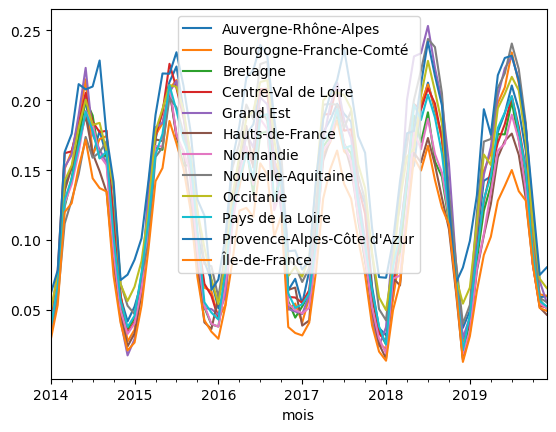

In [24]:
# Chemin vers le fichier CSV
filepath = "normalized_production_solaire_2014_2019.csv"
df_energy = pd.read_csv(filepath, index_col=0, header=0, parse_dates=True)
plt.figure()
df_energy.plot()
df_energy = df_energy.rename(columns={'Provence-Alpes-Côte d\'Azur': 'PACA'})
df_energy = df_energy.rename(columns={'Île-de-France': 'Ile-de-France'})
df_energy = df_energy.rename(columns={'Pays de la Loire': 'Pays-de-la-Loire'})

Visualisation des données de production

Concaténation des données

In [25]:
 #combiner toutes les datas du dossier climat
import os
# Liste des noms de variables (ou parties variables du nom de fichier)
variable_names = ['height_500','meridional_wind', 'surface_density','surface_downward_radiation','surface_specific_humidity','surface_temperature','upper_meridional_wind','upper_zonal_wind','zonal_wind']

processed_datasets = []

for variable_name in variable_names:
    filename = filename_climate.format(variable_name)
    filepath = Path(data_dir_climate, filename)

    if os.path.exists(filepath):  # Vérifiez si le fichier existe
        da_climate = xr.load_dataset(filepath)

        # Calculez la moyenne régionale
        da_climate_reg = da_climate.groupby(da_mask).mean().rename(mask='region')
        da_climate_reg['region'] = ds_mask['region'].values

        # Ajoutez le résultat à la liste des ensembles de données traitées
        processed_datasets.append(da_climate_reg)
    else:
        print(f"Le fichier pour {variable_name} n'existe pas : {filepath}")

# Fusionnez tous les ensembles de données traités
combined_data = xr.merge(processed_datasets)
pre_climate = combined_data.to_dataframe()

Etude d'une région, normalisation des données, saisonalité

/opt/conda/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


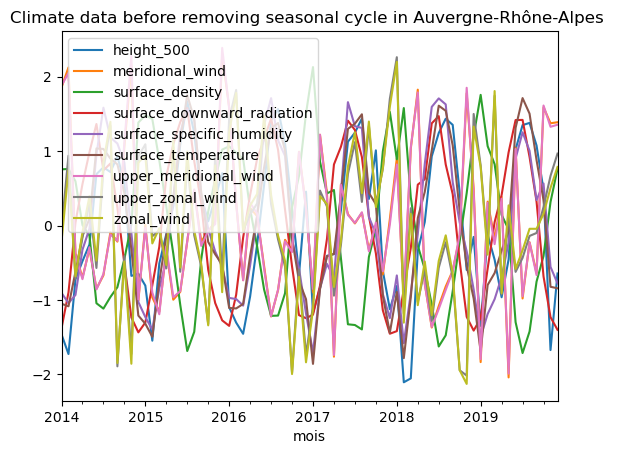

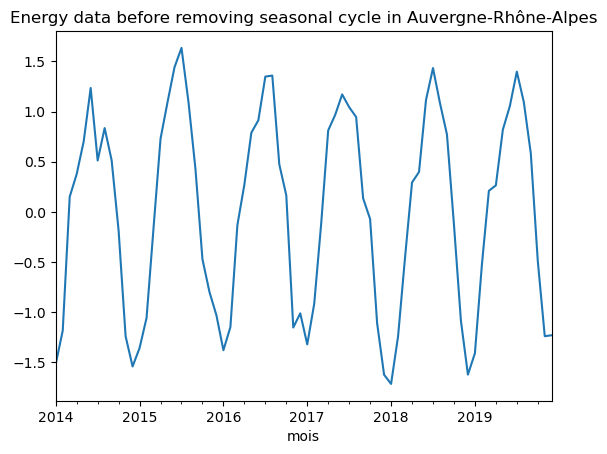

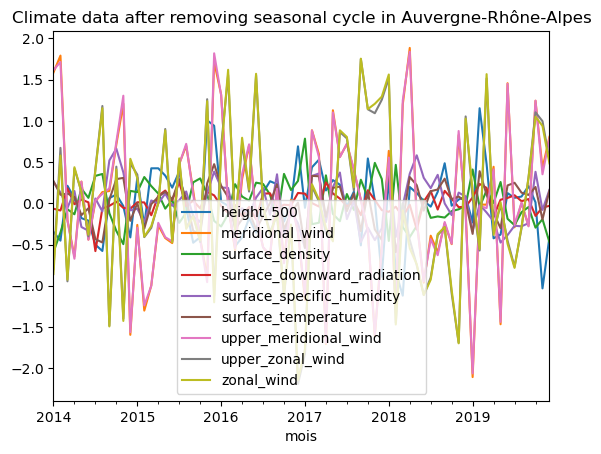

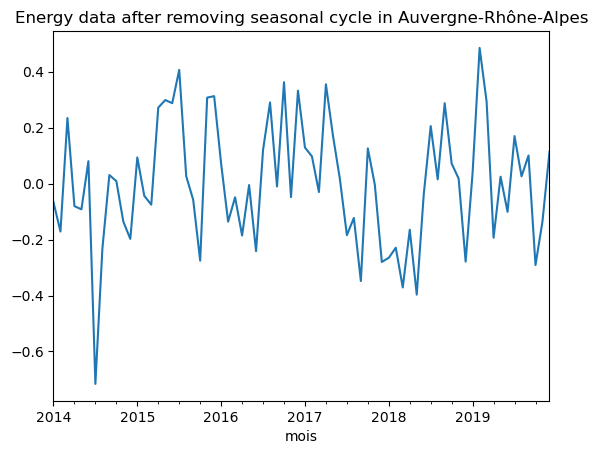

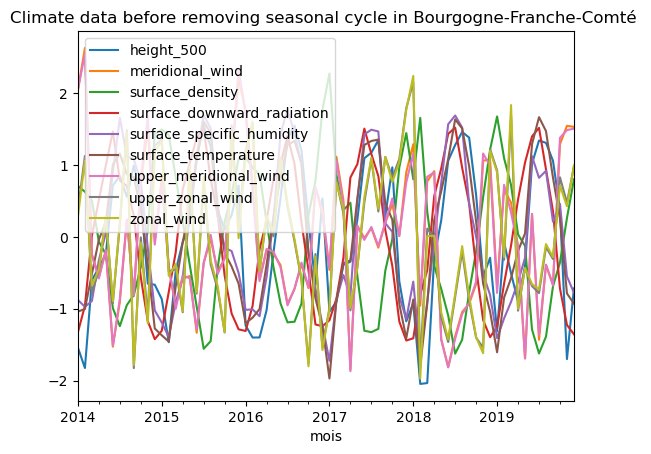

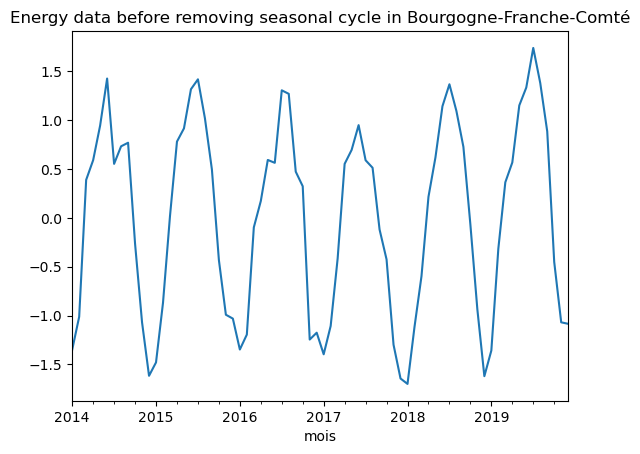

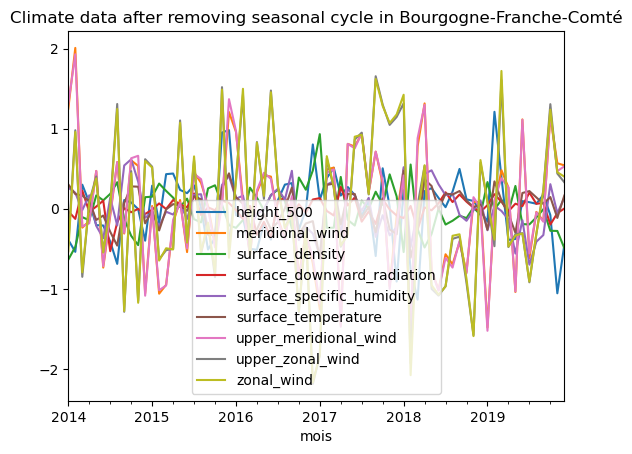

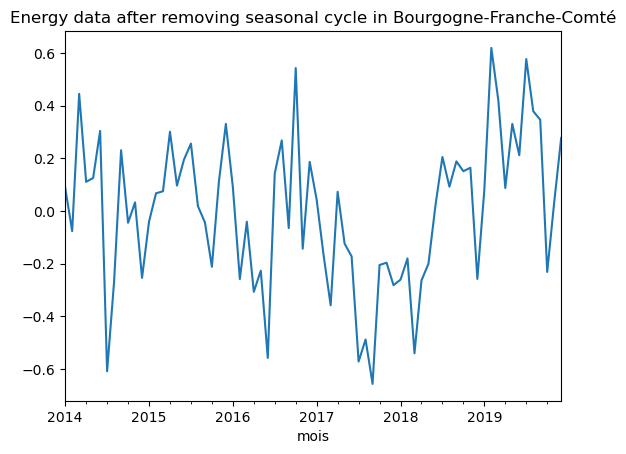

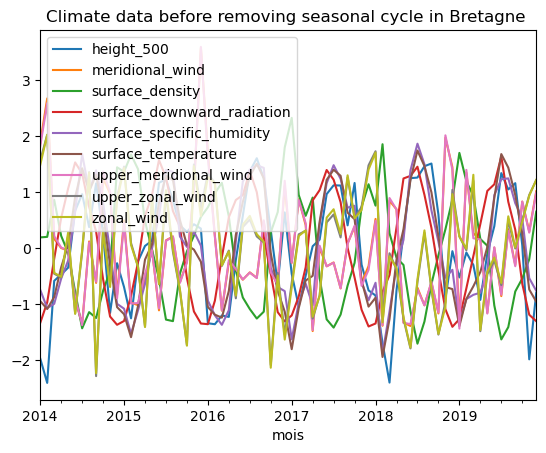

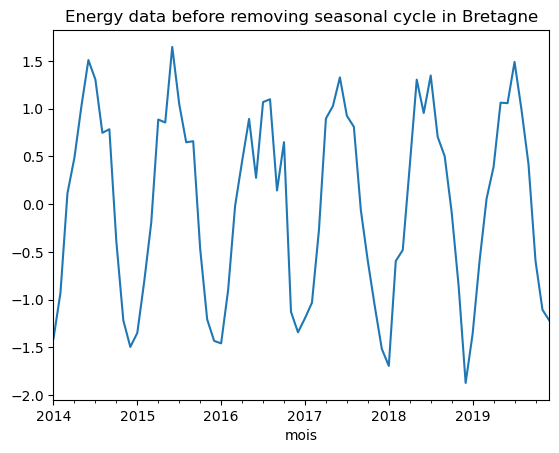

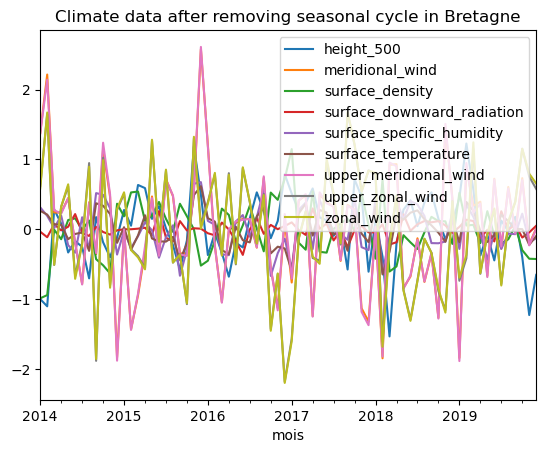

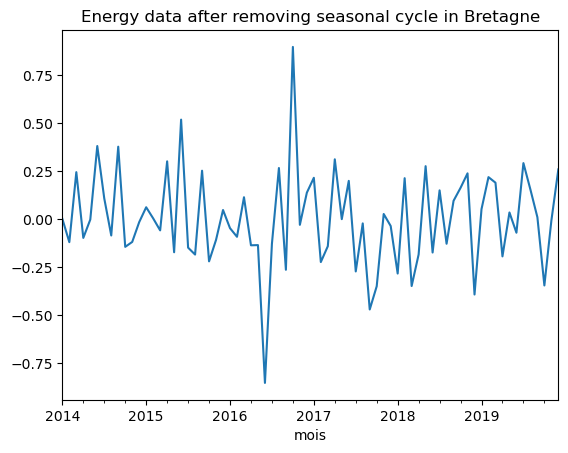

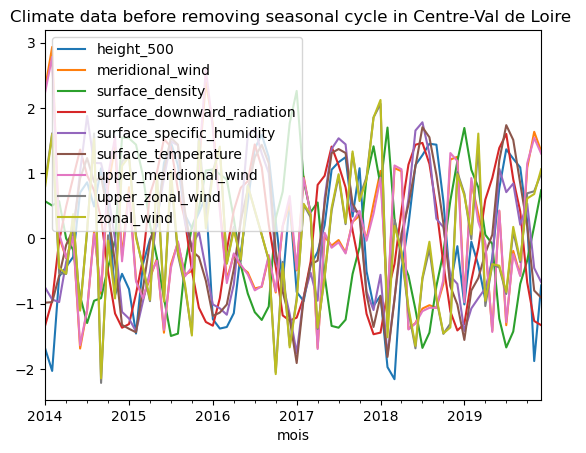

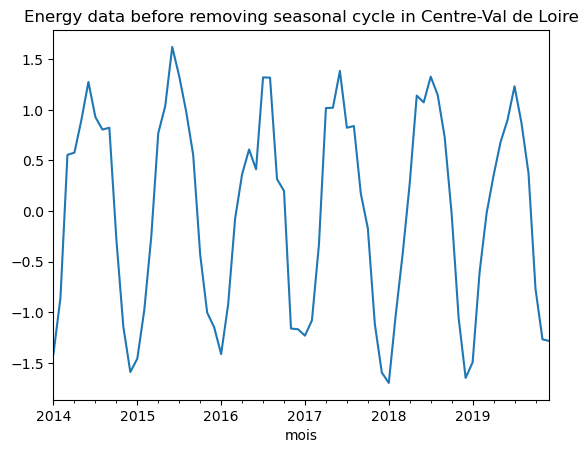

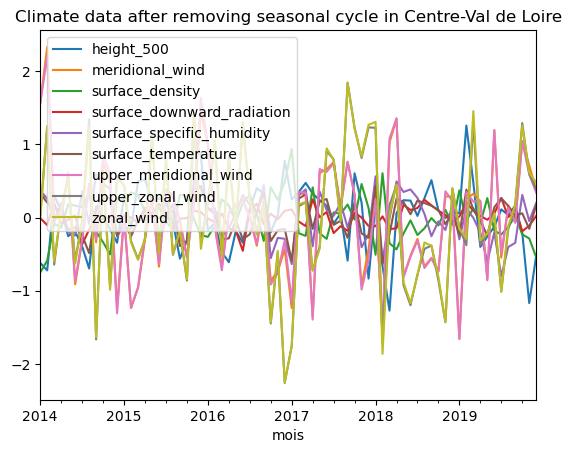

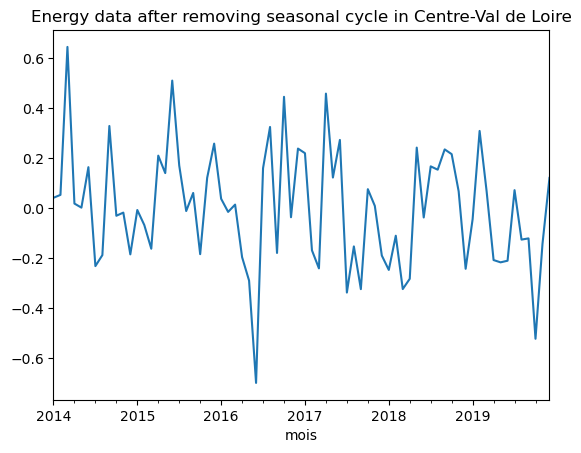

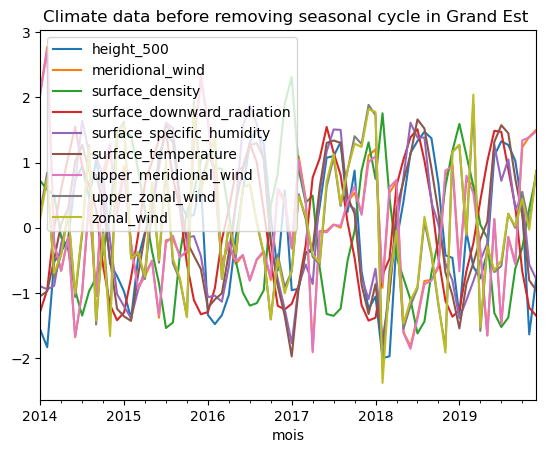

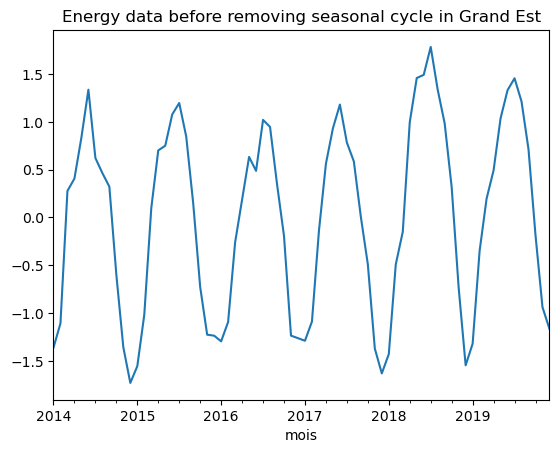

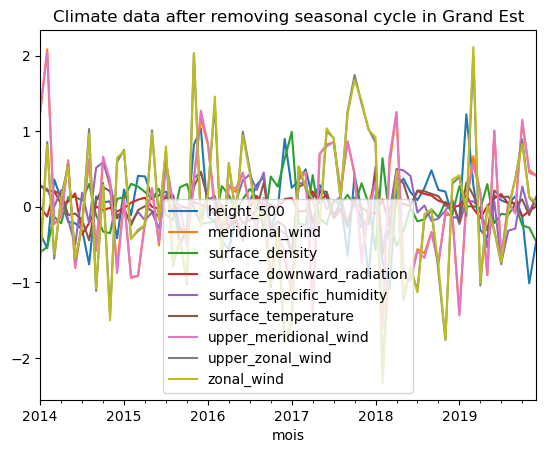

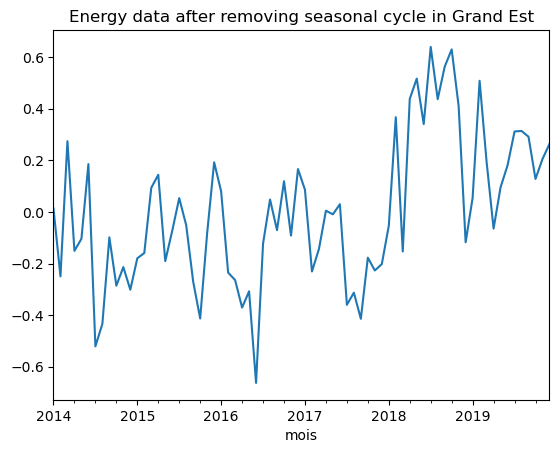

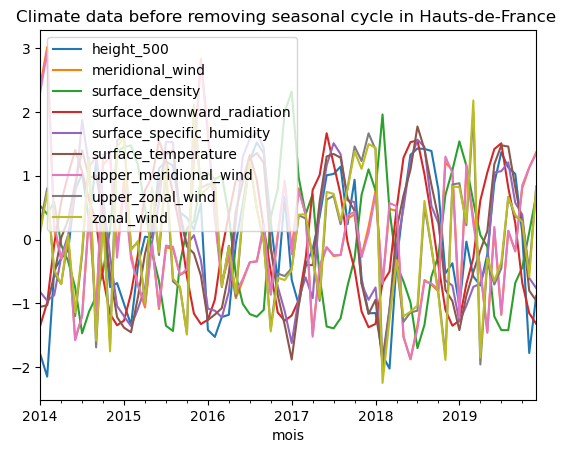

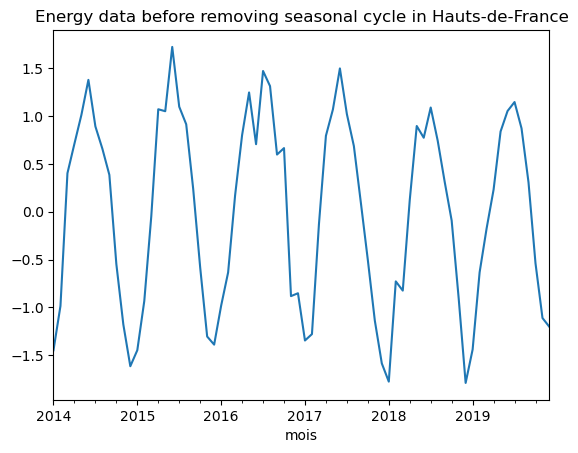

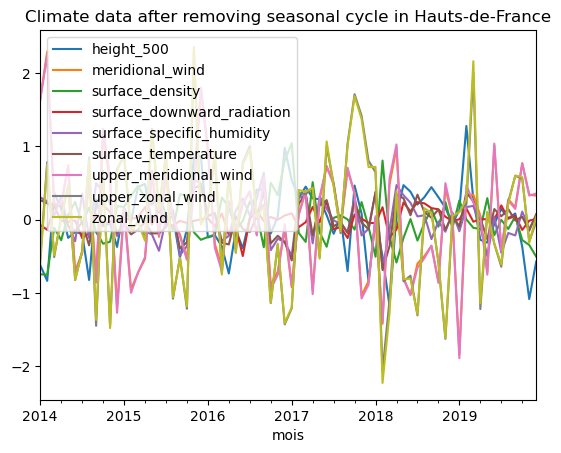

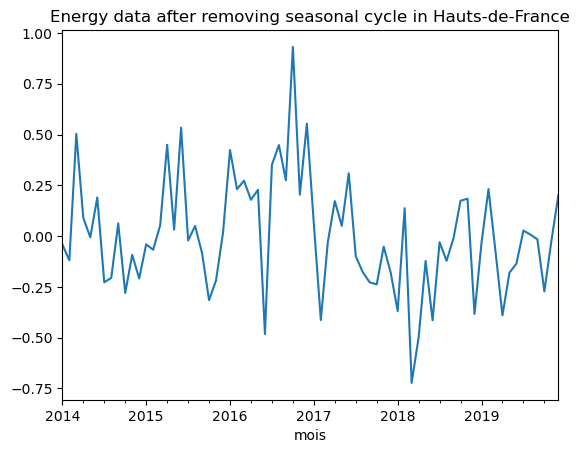

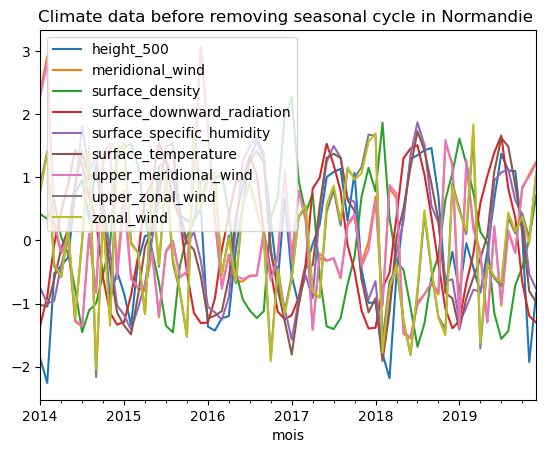

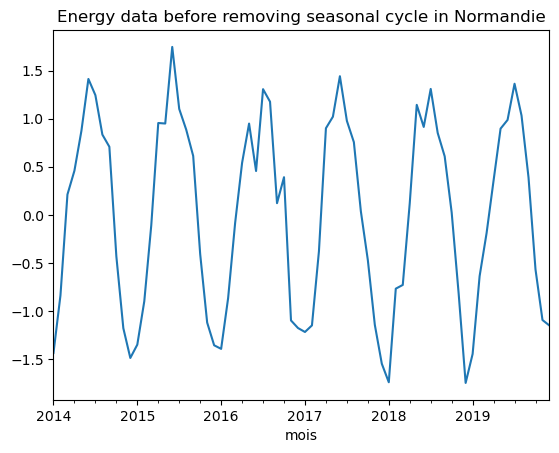

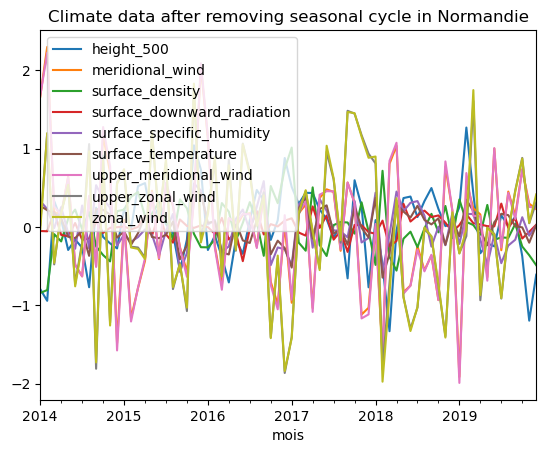

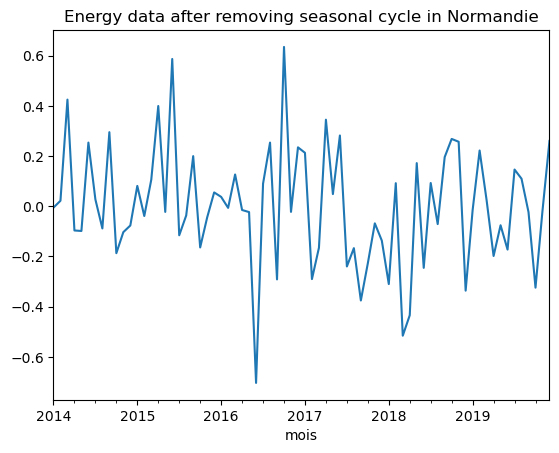

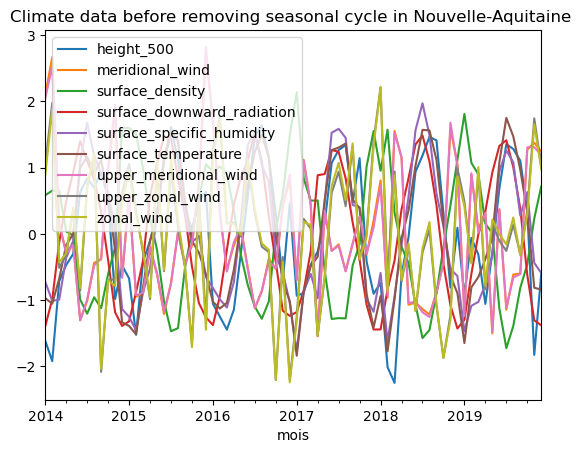

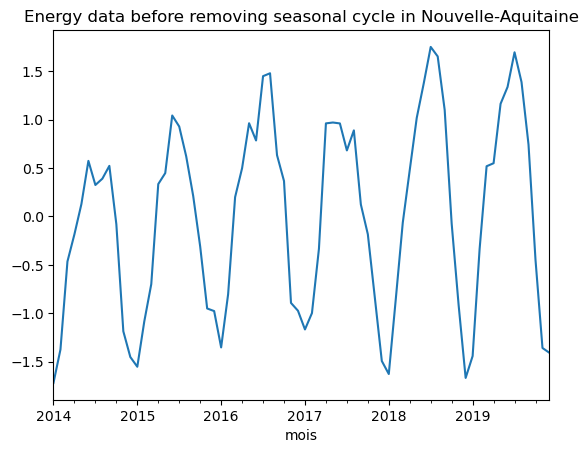

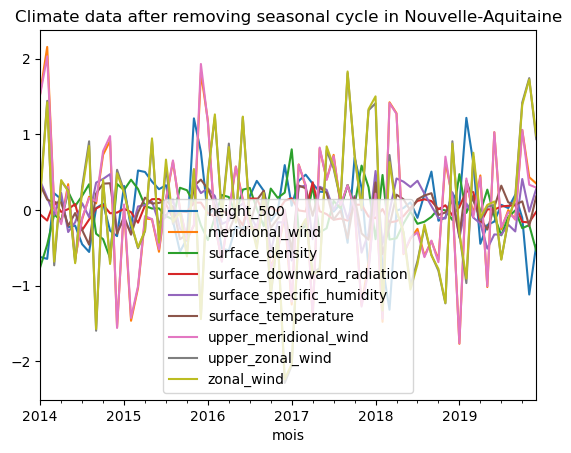

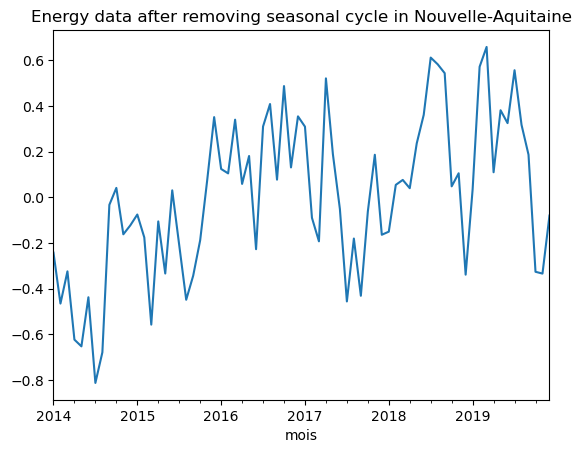

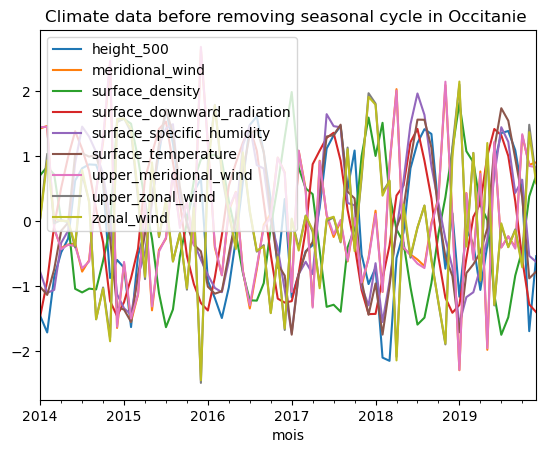

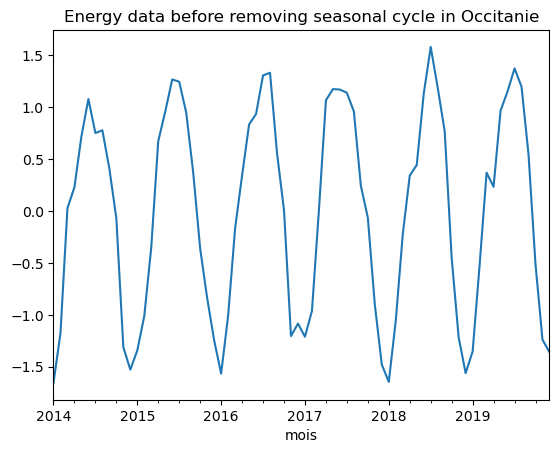

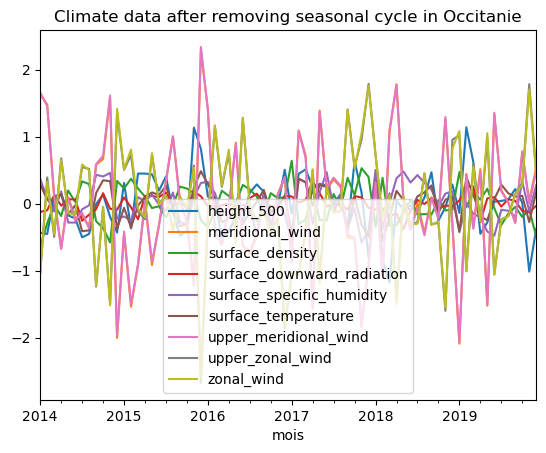

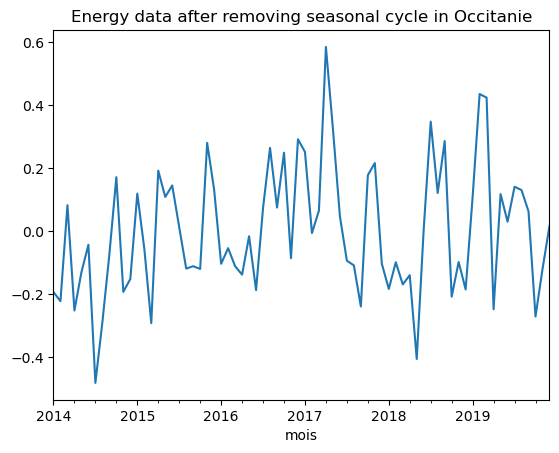

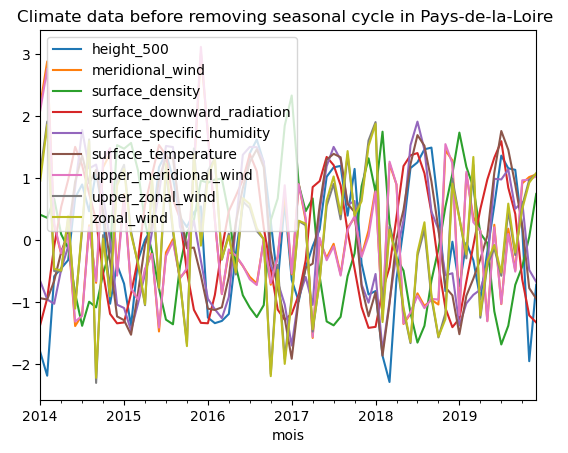

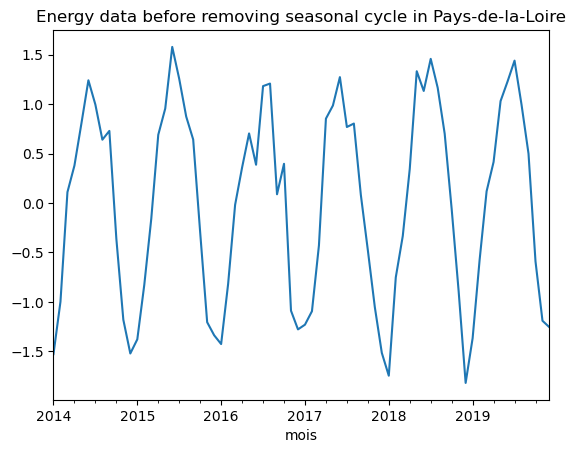

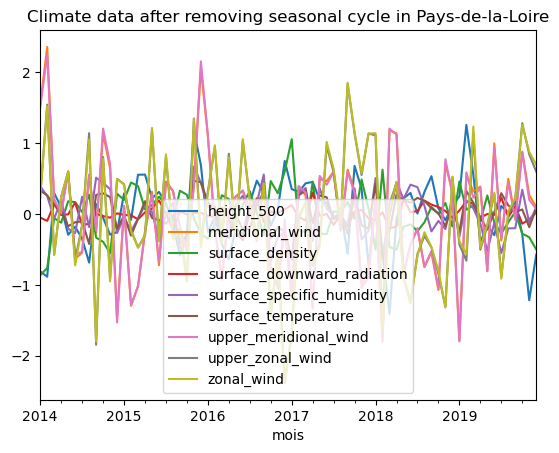

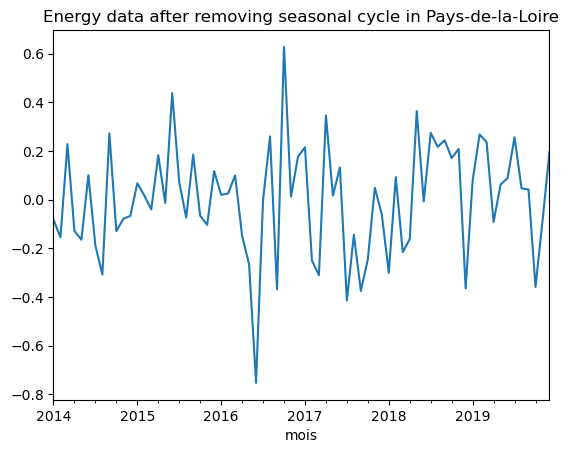

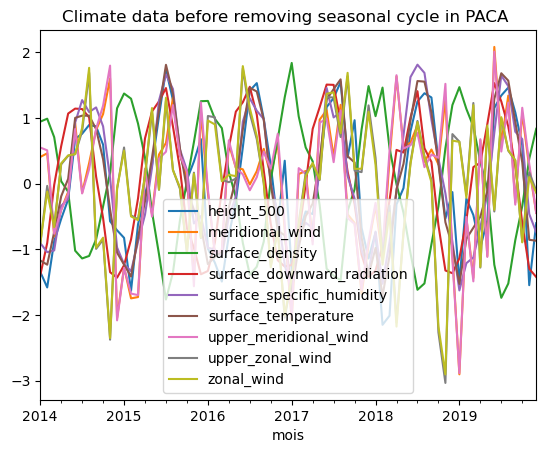

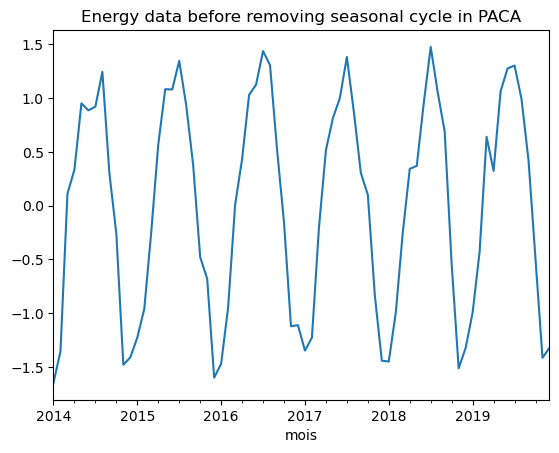

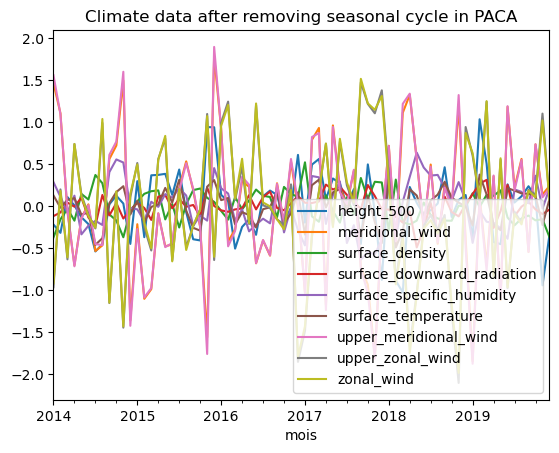

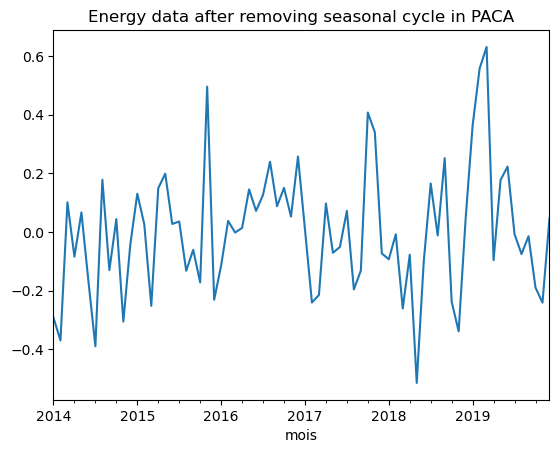

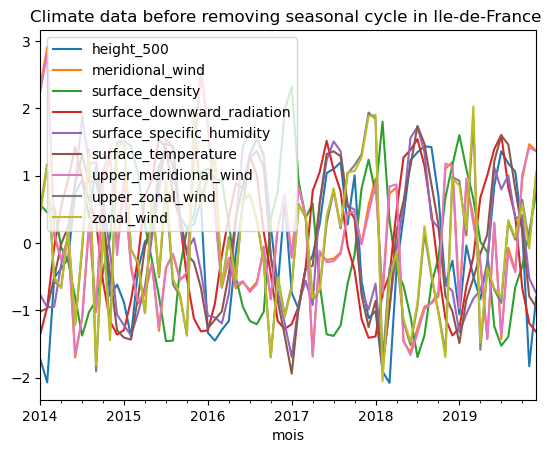

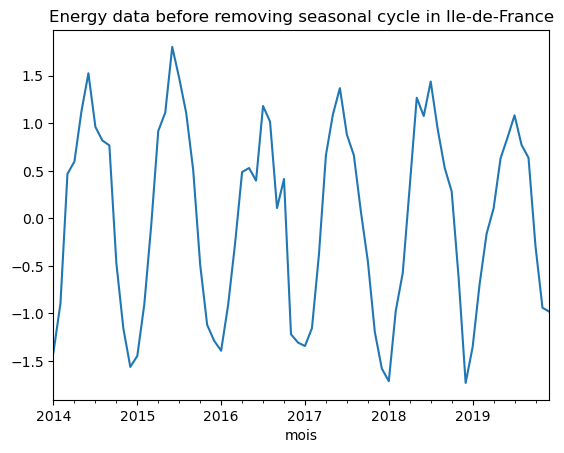

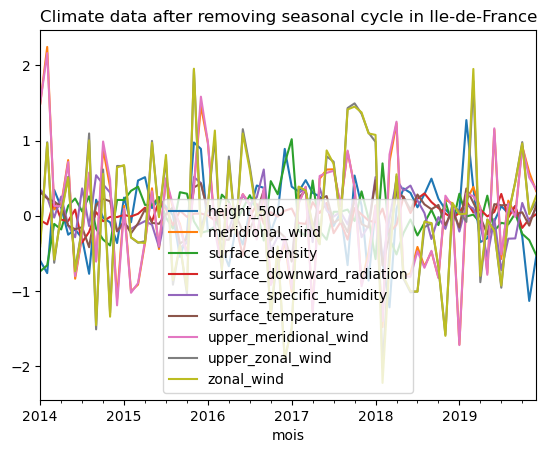

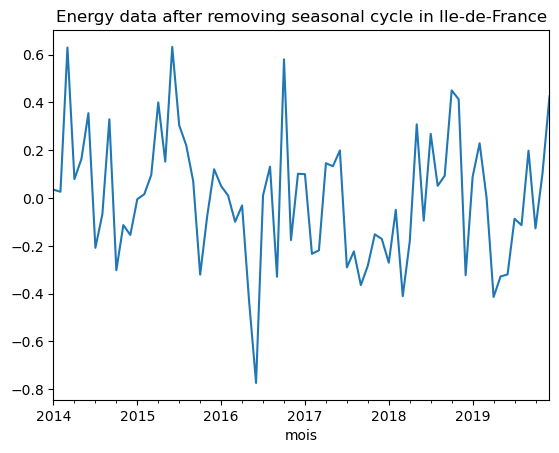

In [26]:
import math

#création de trois dictionnaires qui contiendront les données pour chaque région 
combined_dataframes = {}
energy_data = {}
climate_data={}

for region in region_names:


    # Filtrer 'pre_climate' pour obtenir les données de 'REGION_NAME' uniquement.
    cnd = pre_climate.index.get_level_values("region") == region
    climate_proj = pre_climate[cnd]
    climate_proj.index = climate_proj.index.droplevel("region")

    # Sélectionner les données énergétiques pour la même région.
    energy= df_energy[region]


    # Création d'un nouveau DataFrame 'climate' avec les mêmes indices que 'energy' (mois) 
    # et les mêmes colonnes que 'climate_proj', initialisé avec des valeurs NaN.
    climate = pd.DataFrame(index=energy.index, columns=climate_proj.columns, dtype=np.float64)

    # Calcul de la moyenne mensuelle des données climatiques pour chaque date dans 'climate'.
    for date in climate.index:
        climate.loc[date] = climate_proj[(climate_proj.index.get_level_values("time") >= date) & (climate_proj.index.get_level_values("time") < date + pd.Timedelta(days=30))].mean()

    # Normaliser les données climatiques et énergétiques. 
    climate = (climate - climate.mean()) / climate.std()
    energy = (energy - energy.mean()) / energy.std()
    climate.plot()
    plt.title(f'Climate data before removing seasonal cycle in {region} ')
    plt.figure()
    energy.plot()
    plt.title(f'Energy data before removing seasonal cycle in {region}')

    #enlever la saisonalité par région
    # Calcul des moyennes mensuelles pour chaque mois pour les données climatiques et énergétiques.
    avgs_climate = {}
    avgs_energy = {}
    for month in range(1, 13):
        avgs_climate[month] = climate[climate.index.get_level_values("mois").month == month].mean()
        avgs_energy[month] = energy[energy.index.get_level_values("mois").month == month].mean()
    
    # Soustraction des moyennes mensuelles des données originales pour chaque date.
    for date in energy.index:
        climate.loc[date] -= avgs_climate[date.month]
        energy.loc[date] -= avgs_energy[date.month]
    climate.plot()    
    plt.title(f'Climate data after removing seasonal cycle in {region}')
    plt.figure()
    energy.plot()
    plt.title(f'Energy data after removing seasonal cycle in {region}')
    #ajout en mémoire dans les dictionnaires
    energy_data[f"energy_{region}"] = energy
    climate_data[f"climate_{region}"] = climate
    
  # Concaténation des données climatiques et énergétiques en un seul DataFrame
    combined = pd.concat([climate, energy], axis=1)
    
    # Stockage du DataFrame dans le dictionnaire avec un nom clé dynamique
    combined_dataframes[f"combined_{region}"] = combined
    



In [27]:
# Par exemple, pour accéder au DataFrame de la Bretagne 
combined_region1 = combined_dataframes["combined_Bretagne"]
combined_region1.describe()

height_500  meridional_wind  surface_density  \
count  7.200000e+01     7.200000e+01     7.200000e+01   
mean   2.467162e-17    -1.233581e-17     1.233581e-17   
std    5.060146e-01     8.630644e-01     3.841257e-01   
min   -1.531975e+00    -1.844869e+00    -9.868284e-01   
25%   -2.770593e-01    -4.776723e-01    -2.267403e-01   
50%    4.873415e-02     5.710567e-02     8.749739e-03   
75%    2.959809e-01     4.707020e-01     1.882441e-01   
max    1.227106e+00     2.576050e+00     1.147151e+00   

       surface_downward_radiation  surface_specific_humidity  \
count                7.200000e+01               7.200000e+01   
mean                -5.088522e-17               1.233581e-17   
std                  1.188278e-01               3.193381e-01   
min                 -3.657399e-01              -6.668811e-01   
25%                 -5.841169e-02              -2.583841e-01   
50%                 -1.935136e-03              -3.455359e-02   
75%                  6.893022e-02               2.090487e-01   
max                  2.988438e-01               6.753567e-01   

       surface_temperature  upper_meridional_wind  upper_zonal_wind  \
count         7.200000e+01              72.000000         72.000000   
mean          2.775558e-17               0.000000          0.000000   
std           2.530447e-01               0.869011          0.844973   
min          -6.454960e-01              -1.884220         -2.178628   
25%          -1.814296e-01              -0.471032         -0.519829   
50%          -2.487619e-02               0.076923         -0.100495   
75%           2.088102e-01               0.487665          0.617631   
max           6.168538e-01               2.609080          1.667280   

         zonal_wind      Bretagne  
count  7.200000e+01  7.200000e+01  
mean  -6.167906e-18 -3.083953e-18  
std    8.556308e-01  2.528975e-01  
min   -2.197068e+00 -8.527084e-01  
25%   -5.233236e-01 -1.419226e-01  
50%   -1.006772e-01 -1.202979e-02  
75%    6.463058e-01  1.695572e-01  
max    1.678085e+00  8.963736e-01

### Etude de la corrélation entre les variables pour une région donnée

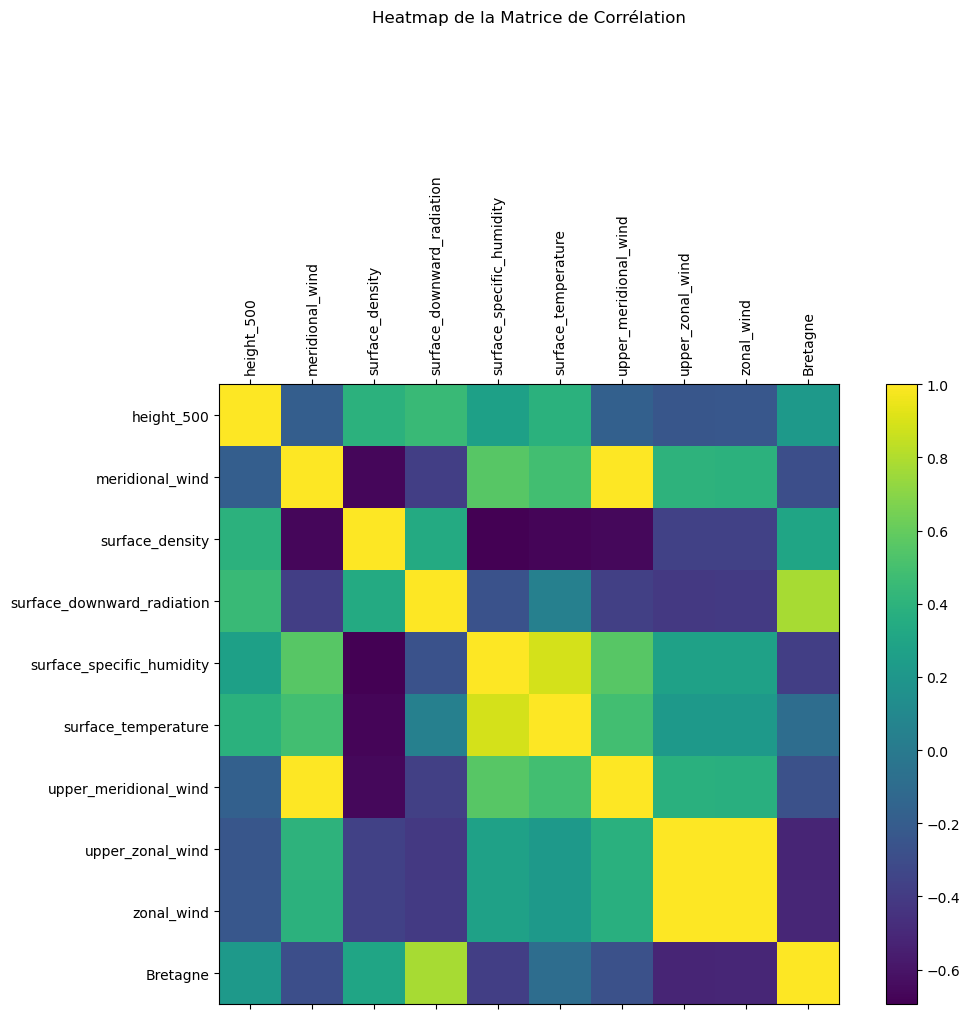

In [28]:
REGION_NAME = 'Bretagne'

# Construction du nom de clé pour accéder au DataFrame combiné
combined_key = f"combined_{REGION_NAME}"

# Calcul de la matrice de corrélation entre les variables climatiques et énergétiques.
correlation_matrix = combined_dataframes[combined_key].corr(method='pearson')

# Affichage de la matrice de corrélation sous forme de carte thermique (heatmap).
# Création de la heatmap avec les noms de colonnes
plt.figure(figsize=(12, 8))  # Adjust the size as needed
plt.matshow(correlation_matrix, fignum=1)
plt.xticks(range(len(combined.columns)), combined_dataframes[combined_key].columns, rotation=90)  # Add x-axis labels
plt.yticks(range(len(combined.columns)), combined_dataframes[combined_key].columns)  # Add y-axis labels
plt.colorbar()
plt.title("Heatmap de la Matrice de Corrélation", pad=110)
plt.show()

In [29]:
# Calculating correlations with 'energy'
energy_correlations = correlation_matrix[REGION_NAME]

# Using absolute values to consider both strong positive and strong negative correlations
energy_correlations_abs = energy_correlations.abs().sort_values(ascending=False)

# Display the correlation values
print(f'Les variables les plus corrélées avec les capacity factors dans la région {REGION_NAME} sont: ')
print(energy_correlations_abs[1:])


Les variables les plus corrélées avec les capacity factors dans la région Bretagne sont: 
surface_downward_radiation    0.776150
upper_zonal_wind              0.517262
zonal_wind                    0.512733
surface_specific_humidity     0.378778
surface_density               0.299260
meridional_wind               0.285184
upper_meridional_wind         0.277296
height_500                    0.221354
surface_temperature           0.085886
Name: Bretagne, dtype: float64


### Etude de la corrélation pour toutes les régions

In [30]:

top_correlations_per_region = {}

for region in region_names:
    combined_key = f"combined_{region}"

    if combined_key in combined_dataframes:
        # Calculer la matrice de corrélation
        correlation_matrix = combined_dataframes[combined_key].corr()

        # Obtenir les cinq variables les plus corrélées (en valeur absolue) pour la région
        
        top_vars = correlation_matrix[region].abs().sort_values(ascending=False)[1:6]
        top_correlations_per_region[region] = top_vars
    else:
        print(f"La région {region} n'est pas présente dans les données combinées.")

# Afficher les résultats
for region, correlations in top_correlations_per_region.items():
    print(f"Région {region} - Top 5 variables corrélées :")
    print(correlations)
    print()  

Région Auvergne-Rhône-Alpes - Top 5 variables corrélées :
surface_downward_radiation    0.864843
height_500                    0.641391
surface_temperature           0.373089
upper_zonal_wind              0.292005
zonal_wind                    0.284828
Name: Auvergne-Rhône-Alpes, dtype: float64

Région Bourgogne-Franche-Comté - Top 5 variables corrélées :
surface_downward_radiation    0.744298
upper_zonal_wind              0.449397
zonal_wind                    0.435217
height_500                    0.415541
surface_temperature           0.261358
Name: Bourgogne-Franche-Comté, dtype: float64

Région Bretagne - Top 5 variables corrélées :
surface_downward_radiation    0.776150
upper_zonal_wind              0.517262
zonal_wind                    0.512733
surface_specific_humidity     0.378778
surface_density               0.299260
Name: Bretagne, dtype: float64

Région Centre-Val de Loire - Top 5 variables corrélées :
surface_downward_radiation    0.801977
height_500                    0

In [31]:
# Variables avec la plus haute corrélation moyenne à travers toutes les régions
top_correlations = pd.Series(dtype=float)

for region in region_names:
    combined_key = f"combined_{region}"

    if combined_key in combined_dataframes:
        # Calculer la matrice de corrélation pour la région spécifique
        correlation_matrix = combined_dataframes[combined_key].corr()

        # On obtient les corrélations absolues par rapport à la variable cible pour la région, en excluant l'autocorrélation
        region_correlations = correlation_matrix[region].abs().drop(region)

        # Mettre à jour la série des corrélations en conservant la moyenne des corrélations pour chaque variable
        top_correlations = pd.concat([top_correlations, region_correlations], axis=1).mean(axis=1)

# Trier les résultats pour obtenir les plus hautes corrélations moyennes
top_correlations = top_correlations.sort_values(ascending=False)

# Afficher les variables avec la plus haute corrélation moyenne à travers toutes les régions
print("Variables avec la plus haute corrélation moyenne à travers toutes les régions :")
print(top_correlations.head(5))

Variables avec la plus haute corrélation moyenne à travers toutes les régions :
surface_downward_radiation    0.675575
upper_zonal_wind              0.367857
zonal_wind                    0.359182
height_500                    0.315287
upper_meridional_wind         0.305468
dtype: float64


# Regression

### Choix de la région et définition des X_train, X_test, y_train, y_test

In [32]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#choix de la région d'étude
region_name = "Bretagne"
X = climate_data[f"climate_{region_name}"].values
y = energy_data[f"energy_{region_name}"].values

# diviser le data set en deux parties
X = climate.values
y = energy.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Ridge regression

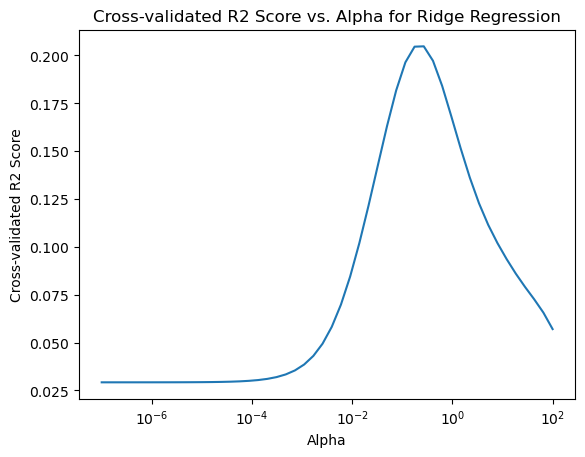

Meilleur alpha : 0.26826957952797276
Meilleur R2 associé : 0.20479216984914936
Mean squared error: 0.05
R2_test: -0.39


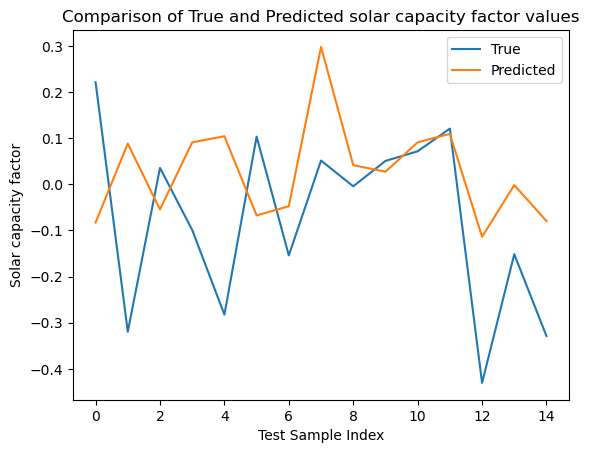

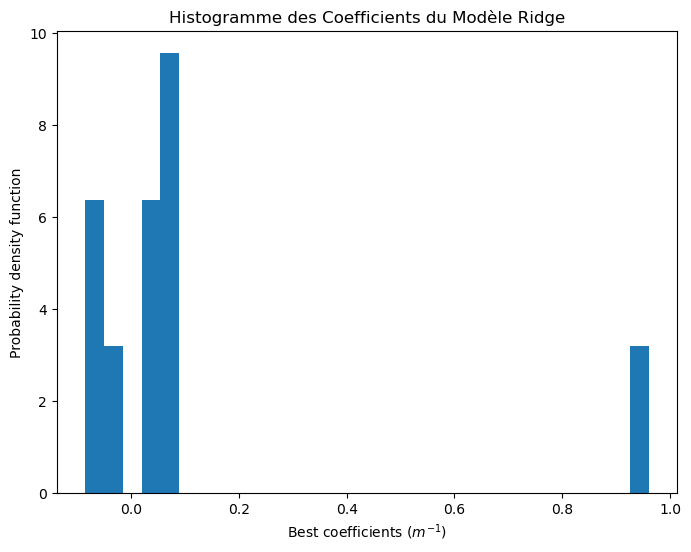

In [33]:
#Réaliser une cross validation sur X_train, y_train
value_tab = {}
for alpha in np.logspace(-7, 2, 50):
    model = Ridge(alpha=alpha)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="r2")
    value_tab[alpha] = cv_scores.mean()

#plt.plot(value_tab.keys(), value_tab.values())

# Convertissez les clés et les valeurs en listes
alphas = list(value_tab.keys())
cv_means = list(value_tab.values())

plt.plot(alphas, cv_means)
plt.xlabel('Alpha')
plt.ylabel('Cross-validated R2 Score')
plt.xscale('log')  #  échelle logarithmique sur l'axe x pour une meilleure visualisation
plt.title('Cross-validated R2 Score vs. Alpha for Ridge Regression')
plt.show()


def find_best_alpha(value_tab):
    best_alpha = max(value_tab, key=value_tab.get)
    best_r2 = value_tab[best_alpha]
    
    return best_alpha, best_r2

# Utilisation de la fonction pour trouver le meilleur alpha
best_alpha, best_r2_ridge = find_best_alpha(value_tab)

print(f"Meilleur alpha : {best_alpha}")
print(f"Meilleur R2 associé : {best_r2_ridge}")

#prédiction 

ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train, y_train)


y_pred = ridge_model.predict(X_test)
mse_ridge=mean_squared_error(y_test,y_pred)
print("Mean squared error: %.2f"
        % mse_ridge)

# plot results
print("R2_test: %.2f"
        %ridge_model.score(X_test, y_test))


plt.figure()
plt.plot(y_test, label="True")
plt.plot(y_pred, label="Predicted")
plt.title('Comparison of True and Predicted solar capacity factor values') 
plt.xlabel('Test Sample Index')  
plt.ylabel('Solar capacity factor')  
plt.legend()


coefs_best = ridge_model.coef_

# Création de l'histogramme des coefficients

plt.figure(figsize=(8, 6)) 
plt.hist(coefs_best, bins=30, density=True)  
plt.xlabel(r'Best coefficients ($m^{-1}$)')
plt.ylabel('Probability density function')
plt.title('Histogramme des Coefficients du Modèle Ridge')
plt.show()

### Nested cross validation

In [34]:
#nested cross validation 

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
ALPHA_RNG_RIDGE = np.logspace(-7, 2, 50)
complexity_rng = ALPHA_RNG_RIDGE

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Number of splits for test
n_splits_test = 7  # You can adjust this value
# Number of splits for cross-validation
n_splits_cv = n_splits_test - 1

# Define k-fold iterator for the test set
kf_test = KFold(n_splits=n_splits_test)

# Loop over the train and test indices
r2_test_arr = np.empty((n_splits_test,))
mse_test_arr = np.empty((n_splits_test,))
complexity_best_arr = np.empty((n_splits_test,))

for itest, (cv_index, test_index) in enumerate(kf_test.split(X)):  # Use X_test, y_test for testing
    # Select cross-validation data
    X_cv = X[cv_index]
    y_cv = y[cv_index]

    # Select test set for later
    X_test_fold = X[test_index]
    y_test_fold = y[test_index]

    # Declare empty arrays in which to store r2 scores and coefficients
    r2_validation = np.empty(complexity_rng.shape)
    coefs = np.empty((len(complexity_rng), X.shape[1]))

    # Loop over regularization-parameter values
    for k, complexity in enumerate(complexity_rng):
        # Define the Ridge estimator for particular regularization-parameter value
        reg = Ridge(alpha=complexity)

        # Get r2 test scores from k-fold cross-validation
        r2_validation_arr = cross_val_score(reg, X_cv, y_cv, cv=n_splits_cv, scoring="r2")

        # Get r2 expected prediction score by averaging over test scores
        r2_validation[k] = r2_validation_arr.mean()

        # Save coefficients
        reg.fit(X_cv, y_cv)
        coefs[k] = reg.coef_

    # Get the best values of the regularization parameter, prediction R2, and coefficients
    k_best = np.argmax(r2_validation)
    complexity_best_arr[itest] = complexity_rng[k_best]

    # Define the Ridge estimator for best regularization parameter value
    reg = Ridge(alpha=complexity_best_arr[itest])

    # Fit on train data
    reg.fit(X_cv, y_cv)
    y_pred = reg.predict(X_test_fold)

    # Test on test data and add r2_test and mse_test values to the lists
    r2_test_arr[itest] = reg.score(X_test_fold, y_test_fold)
    mse_test_arr[itest]= mean_squared_error(y_test_fold, y_pred)


# Get mean R2 and MSE
r2_test_mean = r2_test_arr.mean()
r2_test_std = r2_test_arr.std()

mse_test_mean = mse_test_arr.mean()
mse_test_std = mse_test_arr.std()

complexity_best_mean = complexity_best_arr.mean()

print('Test R2: {:.2f} +/- {:.2f} (1/2 std)'.format(r2_test_mean, r2_test_std / 2))
print('Mean squared error: {:.2f} +/- {:.2f} (1/2 std)'.format(mse_test_mean, mse_test_std / 2))
print('Mean best alpha: {:.2e}'.format(complexity_best_mean))


Test R2: -0.40 +/- 0.49 (1/2 std)
Mean squared error: 0.06 +/- 0.02 (1/2 std)
Mean best alpha: 1.98e-01
